<a href="https://colab.research.google.com/github/eshaan90/Anomaly_Detection/blob/master/Unsupervised_Anomaly_detection_using_multivariate_guassian_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Anomaly Detection


Here, we implement an anomaly detection algorithm to detect anomalous behavior in server computers. In the available dataset, each computer server is described by 11 features, capturing features like throughput (mb/s), latency (ms), and many more properties of your compute servers.

While the servers were operating, we collected m = 1000 examples of how they were behaving, and thus have an unlabeled dataset {x(1),...,x(m)}. We suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.


We will use a Gaussian model to detect anomalous examples in the dataset. We will fit a Gaussian distribution on the dataset and then find values that have very low probability and hence can be considered anomalies.

In [94]:
#Import all libraries
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
sns.set(color_codes=True)
print('All libraries imported successfully')

All libraries imported successfully


### Load the data
We have 1000 unlabeled samples in the training data.
We also have 100 labeled samples which would be our validation data and we will use it to estimate the anomaly threshold hyperparameter. 



In [47]:
X = pd.read_csv('ex8data.csv', sep=',',header=None)
Xval = pd.read_csv('ex8data_Xval.csv', sep=',',header=None)
Yval = pd.read_csv('ex8data_yval.csv', sep=',',header=None)
X.head()

,0,1,2,3,4,5,6,7,8,9,10
0,6.6531,13.6900,17.5530,-11.9330,-5.7564,15.4360,-12.13700,8.22410,-4.88400,5.34930,17.351000
1,-5.6305,-18.9380,18.6450,-6.1558,-25.9890,15.4100,-16.59600,9.45470,-2.87720,-6.00940,19.211000
2,9.7215,-9.9825,15.5710,-32.2240,-5.5958,24.3210,0.83277,10.79500,0.72757,10.39300,7.086000
3,-4.6358,-10.7160,20.3570,-9.0021,-4.9206,-4.2620,-1.30580,0.94998,-8.63410,0.19845,0.006771
4,-12.8410,-20.3880,9.4919,-7.0385,-9.9211,-3.7161,-9.38470,-2.32550,-13.51900,11.00700,14.003000


### Digging into the data

We first compare the mean and variance of the training  and validation data. 


In [44]:
#Check number of null values in the dataset
X.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

In [39]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.939392,-9.637276,13.814691,-10.464494,-7.956228,10.199511,-6.019411,7.969822,-6.253171,2.324519,8.473718
std,7.812546,7.297885,7.653357,9.180869,8.082947,9.469143,7.462515,9.340733,5.445985,8.417598,7.110144
min,-17.489000,-38.594000,-9.913800,-35.968000,-35.352000,-19.691000,-32.281000,-23.218000,-22.040000,-23.459000,-20.152000
25%,-0.316873,-14.748500,8.574325,-16.857000,-13.441500,3.845650,-10.927250,1.903375,-10.089250,-3.480075,3.954350
50%,5.307950,-9.713500,13.683500,-10.443500,-8.031750,10.126000,-6.140150,8.256800,-6.277650,2.549750,8.478900
75%,9.988500,-4.861650,18.648750,-4.187375,-2.511050,16.528000,-0.396655,14.180750,-2.540375,7.779650,13.244500
max,28.385000,13.690000,43.322000,16.082000,15.592000,47.132000,25.474000,41.978000,12.090000,26.166000,36.545000


In [40]:
Xval.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,4.521022,-9.396532,14.008735,-9.841114,-7.826361,13.186252,-5.644985,7.332714,-5.916843,2.037115,7.465711
std,9.725760,7.442532,8.141964,8.952478,7.750407,10.286299,7.528258,8.995462,6.127859,9.319395,6.805810
min,-20.522000,-31.672000,-9.314300,-28.991000,-22.508000,-12.313000,-23.247000,-15.290000,-21.869000,-25.928000,-14.352000
25%,-0.947333,-14.073500,8.974625,-17.100500,-13.981000,6.953750,-10.350250,0.303925,-10.194500,-2.341725,2.187525
50%,4.429450,-9.324000,14.385500,-9.267250,-8.974650,13.980000,-6.568800,7.862550,-5.991250,1.525950,9.150700
75%,10.347500,-4.471000,19.663000,-3.113150,-1.701075,18.389250,-1.760675,12.720000,-2.316450,6.870000,11.609750
max,28.086000,15.684000,35.803000,10.646000,14.098000,53.003000,24.357000,36.438000,9.351400,35.369000,21.949000


We see from the above two tables that mean and std is quite similar for all attributes across training and validation data. We can infer that both data are from the same underlying distribution. 

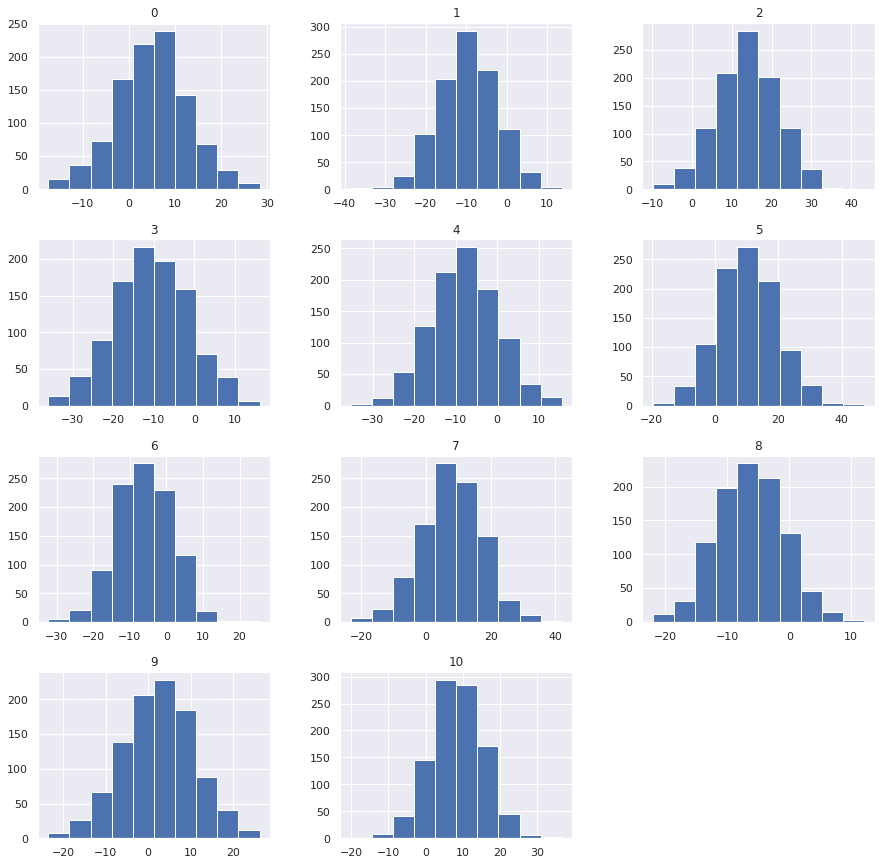

In [43]:
X.hist(figsize=(15,15));

We observe all features to be normally distributed and we cannot find any outliers from the histograms. Let's next look at the correlation between the features. 

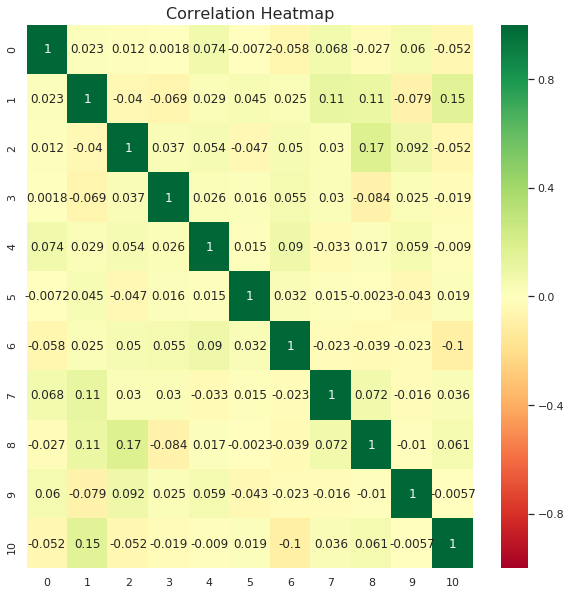

In [77]:
plt.figure(figsize=(10,10))
corr = X.corr()
corr.index = X.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

There isn't any strong correlation between the features. To further understand the bivariate relationships of the data, we analyse pairplots.

<Figure size 432x288 with 0 Axes>

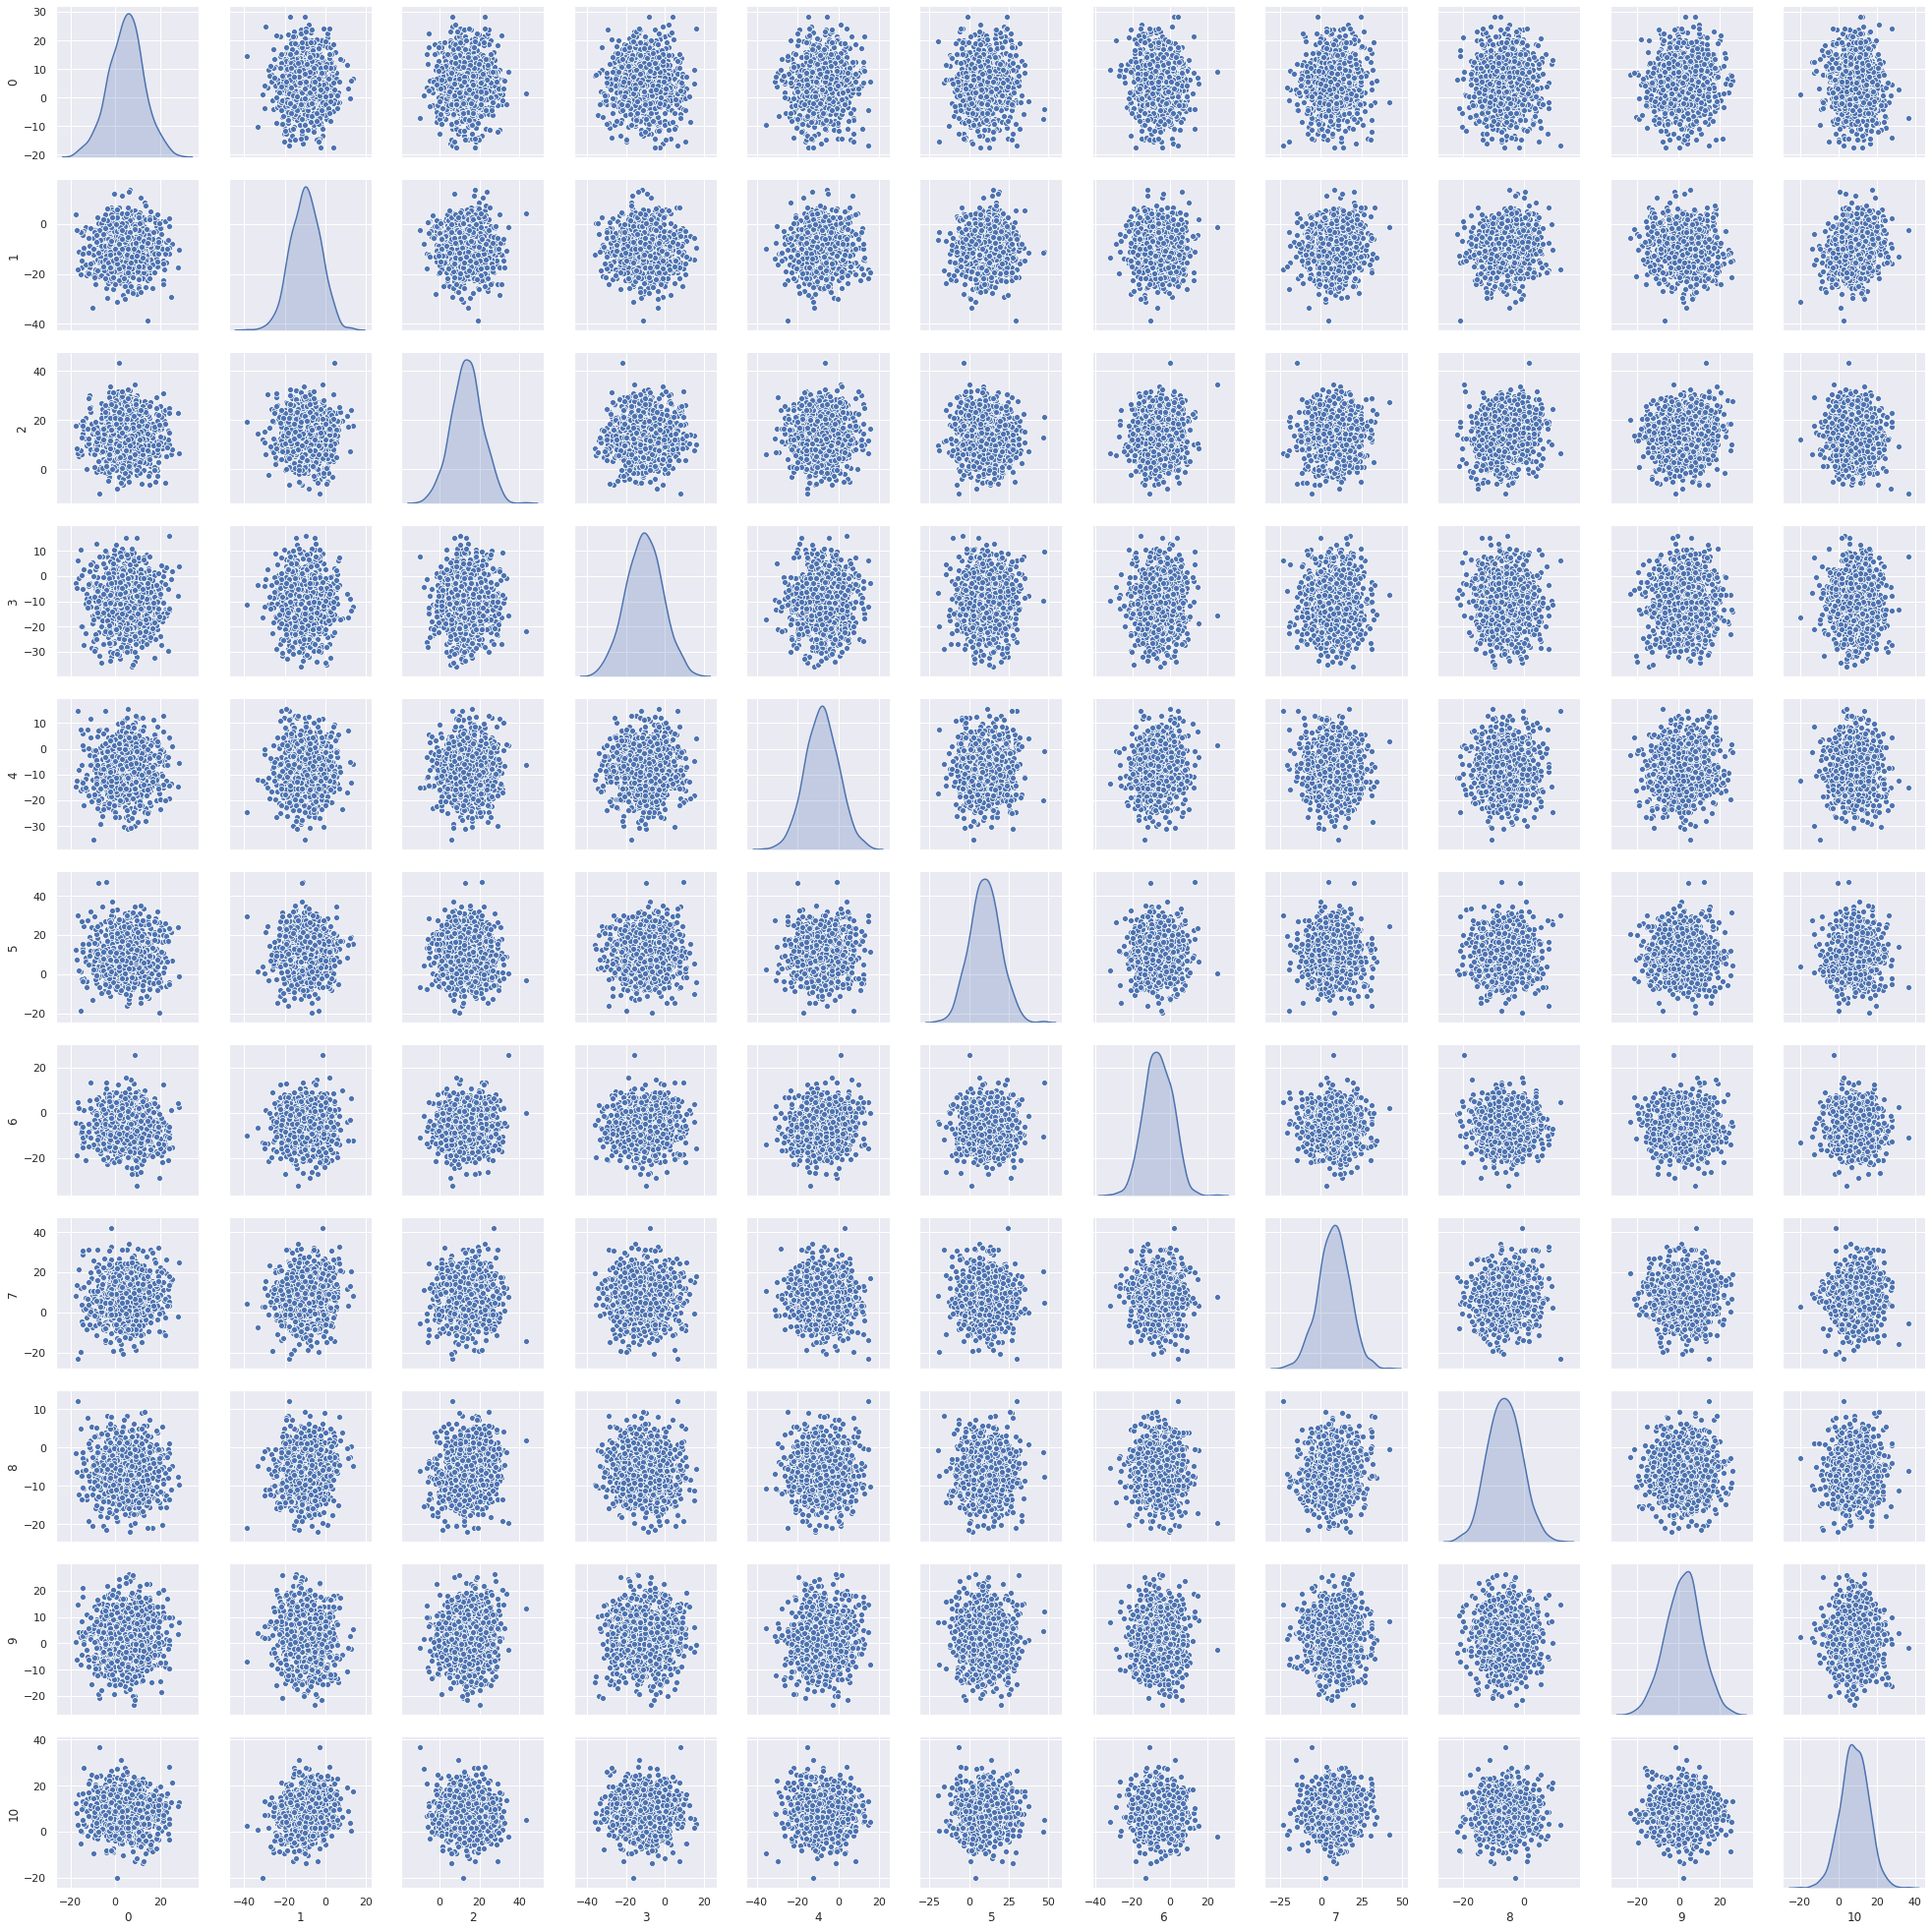

In [78]:
plt.figure();
sns.pairplot(data=X,diag_kind='kde', palette='deep');

The above pairplot confirm that all features are uncorrelated and are randomly distributed. 

#### Principal Component Analysis

As dealing with high dimensional data is often challenging, there are several techniques to reduce the number of variables. One of the main techniques is Principal Component Analysis.

PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. Here we decompose our features into 4 main principal components



In [0]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)

# Random shuffle training data
X_train.sample(frac=1)

X_val = pd.DataFrame(scaler.transform(Xval), 
                             columns=Xval.columns, 
                             index=Xval.index)

In [96]:
pca = PCA(n_components=4, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_val_PCA = pca.transform(X_val)
X_val_PCA = pd.DataFrame(X_val_PCA)
X_val_PCA.index = X_val.index

print('Variance explained by the principal components(in decreasing order): ',pca.explained_variance_ratio_)

Variance explained by the principal components(in decreasing order):  [0.13244516 0.1250439  0.11261282 0.11010755]


Notice that 4 principal components explain only 45% of the variance in the data. Plotting the first two principal components below, which together explain approximately 25% of the total variance. We observe that the training and validation data are similarly spread out.

Text(0.5, 0, 'PCA ')

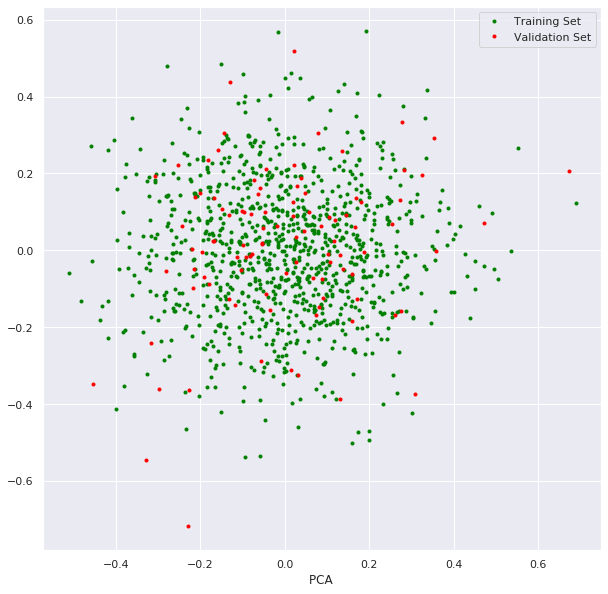

In [97]:
plt.figure(figsize=(10,10))
plt.plot(X_train_PCA.iloc[:,0],X_train_PCA.iloc[:,1],'.',color='green');
plt.plot(X_val_PCA.iloc[:,0],X_val_PCA.iloc[:,1],'.',color='red');
plt.legend(['Training Set','Validation Set'],loc='upper right');
plt.xlabel('PCA ')

As we can see, a lot of useful information is lost when data is reduced to fewer dimensions using PCA. So I infer that using the PCA-transformed data for further model building won't help much in improving anomaly detection performance. We will continue to use the original data.

#### Model Building

In [0]:
def estimateGaussian(X):
    '''
    Function to estimate the Gaussian paramters mu and sigma from the input dataset.
    '''
    m,n=X.shape
    mu=np.zeros((n))
    sigma=np.zeros((n))
    
    for i in range(n):
        mu[i]=sum(X.iloc[:,i])/m
        var_sum=0
        for j in range(m):
            var_sum = var_sum + (X.iloc[j,i]-mu[i])**2
        
        sigma[i]=var_sum/(m-1)
    return mu,sigma

In [0]:
def multivariateGaussian(X, mu, sigma):
    '''
    Computes the probability density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and sigma.  
    sigma is treated as the (sigma)^2 values of the variances in each dimension (a diagonal
    covariance matrix)
    '''
    k = mu.shape[0]
    Sigma2 = np.diag(sigma)
    
    X2=pd.DataFrame.subtract(X, mu)
    p = ((2 * math.pi) ** (- k / 2)) * (np.linalg.det(Sigma2) ** (-0.5)) * np.exp(-0.5 * np.sum( np.dot(X2, np.linalg.pinv(Sigma2))*X2, 1))

    return p

In [0]:
def selectThreshold(Yval,pval):
    '''
    Function to find the best threshold to use for selecting outliers based on the results from a
    validation set (pval) and the ground truth (yval).
    '''
    bestEpsilon, F1, bestF1=0,[],0
    
    stepsize = (max(pval) - min(pval)) / 1000
    epsilon_range = np.arange(min(pval),max(pval),stepsize)
    
    for epsilon in epsilon_range: 
        #Compute the F1 score of choosing epsilon as the threshold and place the value in F1.
        predictions = (pval<epsilon)
        df=pd.DataFrame(data={'Yhat':predictions,'Y':Yval.iloc[:,0]})
        tp = df[(df.Yhat==True) & (df.Y==1)].shape[0]
        fp = df[(df.Yhat==True) & (df.Y==0)].shape[0]
        fn = df[(df.Yhat==False) & (df.Y==1)].shape[0]
        
        #Precision
        if tp+fp==0:
            prec=0
        else:
            prec=tp/(tp+fp)
        
        #Recall
        if tp+fn==0:
            recall=0
        else:    
            recall=tp/(tp+fn)
        # F1
        if prec+recall==0:
            F1.append(0)
        else:
            F1.append((2*prec*recall)/(prec+recall))
     
    idx=np.argmax(F1)
    bestF1=F1[idx]
    bestEpsilon=epsilon_range[idx]
    plt.figure();
    plt.plot(epsilon_range,F1);
    plt.title('F1 vs Thresholds')
    plt.xlabel('Anomalous Threshold')
    plt.ylabel('F1')
    return bestEpsilon,bestF1

In [0]:
# Estimate Gaussian parameters for individual time series
mu,sigma=estimateGaussian(X)

In [0]:
p=multivariateGaussian(X, mu, sigma)
pval=multivariateGaussian(Xval,mu,sigma)

Best epsilon found using cross-validation: %e
 1.3716520768292406e-18
Best F1 on Cross Validation Set:  %f
 0.6153846153846154


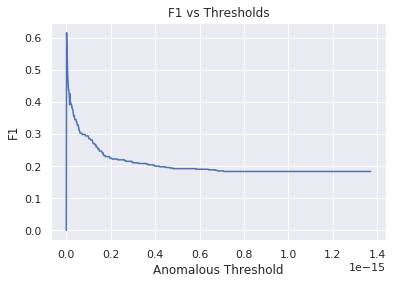

In [91]:
# Select Anomaly detection Threshold where F1 score is the max 
epsilon, F1=selectThreshold(Yval,pval)
print('Best epsilon found using cross-validation: %e\n', epsilon)
print('Best F1 on Cross Validation Set:  %f\n', F1)

In [92]:
# Check how many outliers are found in the original dataset
print('# Outliers found: %d\n\n', sum(p < epsilon))

# Outliers found: %d

 117


In [98]:
#Check validation data accuracy
l=pval<epsilon
print('Validation Accuracy: ',sum(l==True & (Yval.iloc[:,0]==1))/100)

Validation Accuracy:  0.9
